In [1]:
# Internal library imports
from calculations import *
from sqlFunctions import *
from dataAnalysisFunctions import *

# External library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import seaborn as sns
from scipy.stats import skew

In [6]:
# Loading in the galaxy data
galaxyData = pd.read_csv("galaxyDataSave2.csv", delimiter=",")
#galaxyData = pd.read_csv("noAGNdata2/noAGNdataFull.csv", delimiter=",")

# Loading in the velocity and mass data
velocityData = readParticleFiles("linuxData/velocities.txt")
massData = readParticleFiles("linuxData/masses.txt")

#velocityData = readParticleFiles("noAGNdata2/velocities.txt")
#massData = readParticleFiles("noAGNdata2/masses.txt")

# Appending these to our dataframe
galaxyData["ParticleV"] = velocityData
galaxyData["ParticleM"] = massData

# Dropping nulls
galaxyData = removeNulls(galaxyData)

# Binning the galaxy into mass and sfr bins
galaxyData, massBins, sfrBins, massBinVals, sfrBinVals = binGalaxy(galaxyData, 10)

#galaxyData = galaxyData[galaxyData["Theta"] == "0.0"]

c:\Users\Matth\OneDrive\Documents\University [MPhys]\Year 4\PX4310 - Physics Project\Code\dataAnalysisFunctions.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["N Particles"] = pd.to_numeric(df["N Particles"])


In [7]:
# Creating sfr list 
ss = [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

# Generating arrays for the mean velocity and number of galaxies
means = np.zeros((10, 10))
nGals = np.zeros_like(means)
outflowFrac = np.zeros_like(means)
inflowFrac = np.zeros_like(means)
stds = np.zeros_like(means)
skews = np.zeros_like(means)

# Looping through all the sfr bins
for s in tqdm(range(10)):
    # Selecting only data at the current sfr
    dataSFRcut = galaxyData[galaxyData["Binned Sfr"] == s]

    # Looping through all the mass bins
    for m in range(10):
        # Selecting data with current mass
        dataMassCut = dataSFRcut[dataSFRcut["Binned Mass"] == m]

        # Create arrays for masses and velocities
        vels = np.array([])
        mass = np.array([])

        # Loop through every galaxy
        for i in range(len(dataMassCut)):
            # Select current galaxy
            data = dataMassCut.iloc[i]

            # Extracting velocity and mass data
            gv = data["ParticleV"]
            gm = data["ParticleM"]

             # Stripping all the formatting
            gv = gv[:-2]
            gm = gm[:-2]
            gv = gv.strip("][").split(",")
            gm = gm.strip("][").split(",")

            # Putting into arrays
            gv = np.array(gv, dtype=float)
            gm = np.array(gm, dtype=float)      

            # Appending to the final arrays
            vels = np.append(vels, gv)
            mass = np.append(mass, gm)

        velsUpper = vels[vels>100]
        massUpper = mass[vels>100]
        velsLower = vels[vels<-100]
        massLower = mass[vels<-100]

        velsSamp = np.concatenate((velsUpper, velsLower))
        massSamp = np.concatenate((massUpper, massLower))

        # Getting samples
        outflow = vels[vels >= 20]
        inflow = vels[vels <= -20]

        # Calculating properties
        if len(velsSamp) == 0:
            means[s][m] = float("nan")
            nGals[s][m] = float("nan")
            outflowFrac[s][m] = float("nan")
            inflowFrac[s][m] = float("nan")
            stds[s][m] = float("nan")
            skews[s][m] = float("nan")
        else:
            means[s][m] = np.average(velsSamp, weights=massSamp)
            #means[s][m] = np.average(vels)
            nGals[s][m] = len(data)
            stds[s][m] = np.std(vels)
            skews[s][m] = skew(vels)

            if len(outflowFrac) != 0:
                outflowFrac[s][m] = len(outflow) / len(vels)
            else: 
                outflowFrac[s][m] = float("nan")
            if len(inflowFrac) != 0:
                inflowFrac[s][m] = len(inflow) / len(vels)
            else:
                inflowFrac[s][m] = float("nan")

100%|██████████| 10/10 [12:28<00:00, 74.89s/it]


c:\Users\Matth\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
No handles with labels found to put in legend.


(-3.134835370111989, 1.6737695269881112)

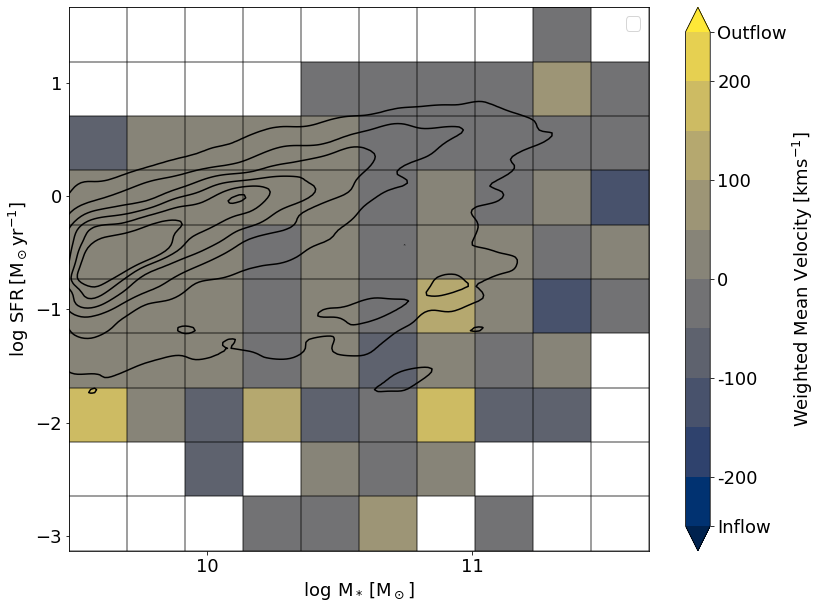

In [8]:
# Extracting mass and sfr
mass = galaxyData["Mass"].to_numpy()
sfr = galaxyData["Star Formation Rate"].to_numpy()

# Setting up the figure
plt.figure(figsize=(13,10))
plt.rcParams.update({"font.size": 18})

# Creating colourmap
cmap = mpl.cm.cividis
#norm = mpl.colors.BoundaryNorm([-100, -20, -10, 10, 20, 100], cmap.N, extend="both")
#norm = mpl.colors.BoundaryNorm([0.2, 0.4, 0.6, 0.8], cmap.N, extend="both")
norm = mpl.colors.BoundaryNorm([-250, -200, -150, -100, -50, 0, 50, 100, 150, 200, 250], cmap.N, extend="both")

# Plotting the colour mesh
plt.pcolormesh(massBinVals, sfrBinVals, means, cmap=cmap, norm=norm)
#plt.plot(mass, sfr, "kx", markersize=1)

# Overlaying the density plot of mass and sfr
sns.kdeplot(x=mass, y=sfr, levels=7, color="k", linewidth=2)

# Creating gridlines to differentiate boxes
plt.vlines(massBinVals, min(sfrBinVals), max(sfrBinVals), "k", alpha=0.5)
plt.hlines(sfrBinVals, min(massBinVals), max(massBinVals), "k", alpha=0.5)

# Setting axes and labels
cbar = plt.colorbar(label="Weighted Mean Velocity $\\rm [kms^{-1}]$", ticks=[-250, -200, -100, 0, 100, 200, 250])
cbar.ax.set_yticklabels(["Inflow", -200, -100, 0, 100, 200, "Outflow"])

plt.xlabel("$\\rm \log \: M_* \:[M_\odot]$")
plt.ylabel("$\\rm \log \: SFR \:[M_\odot yr^{-1}]$")
plt.xticks([10, 11], [10, 11])
plt.legend()

plt.xlim((min(mass), max(mass)))
plt.ylim((min(sfr), max(sfr)))